In [1]:
%load_ext autoreload
%autoreload 2

## RNAAS
<br>**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 12-09-20
<br>**Short description:**
This notebook contains the code to make the figure included in the RNAAS paper.

### 0. Software Setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

mpl.rc_file('../src/lsst_dcr.rc')
%matplotlib inline

In [3]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

## 1. Compare DCR metric to desired slopes
### 1.1 Load in simulated DCR data (used to define metric)

Files created by Tina Peters as part of the efforts discussed at [DCR_AGN_metric_analysis.ipynb](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb), which records the means colors and DCR slopes as a function of redshift for SDSS quasars.  There seems to be some discrepancy between the g-band slopes and the plots of Kaczmarczik et al. 2009, so they should be double-checked before finalizing any quasar-specific DCR metric.

In [5]:
# load in data and merge into one df
dcr_data_dir = '../data/DCR_data/'
dfZ = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshifts.dat'))
dfQSO = pd.read_csv(os.path.join(dcr_data_dir, 'fittingS82_zshiftfit.dat'), \
                                index_col=0, header=None, sep=' ').T.dropna().reset_index(drop=True)
dfDCR = pd.concat([dfZ, dfQSO], axis=1)
dfDCR.head()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
0,0.40,0.3790,0.1143,0.1995,0.2466,0.0012,0.0258
1,0.45,0.2507,0.0644,0.2651,0.2032,0.0053,0.0506
2,0.50,0.2023,0.0410,0.2679,0.1762,0.0002,0.0589
3,0.55,0.3056,0.0252,0.2351,0.1314,-0.0140,0.0357
4,0.60,0.3419,0.0727,0.1867,0.1570,-0.0083,0.0143


### 1.2 Load in metric results

In [6]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

resultDbPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/RNAAS/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/scratch/MAFOutput/DCR/RNAAS/MetricData/'

In [7]:
# import metric evaluations
bundleDicts = {}

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [8]:
# check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'DCR_20_g'), (2, 'DCR_22_g'), (3, 'DCR_24_g'), (4, 'DCR_20.15_u'), (5, 'DCR_22.15_u'), (6, 'DCR_24.15_u')]


__Note:__ The keys you see (in your own notebbook) could be different than what are shown above, which as a result you will need to modify the plotting code below to make the cell run properly.

## 2. Make plots

In [9]:
# return median metric data
def get_dcr_median(mb):
    
    mask = mb.metricValues.mask
    data = mb.metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]
    
    return np.median(data)

# get the median values from all opsims 
# for normaliation in plotting
def get_metric_medians(key, bd, func):
    
    mds = []
    for run in bd:
        keys = [*bd[run].keys()]
        run_key = [elem for elem in keys if elem[1] == key[1]][0]
        mds.append(func(bd[run][run_key]))

    return mds

In [10]:
# get the metrics for plotting
Key1, Key2 = (1, 'DCR_22_g'), (4, 'DCR_22.15_u')

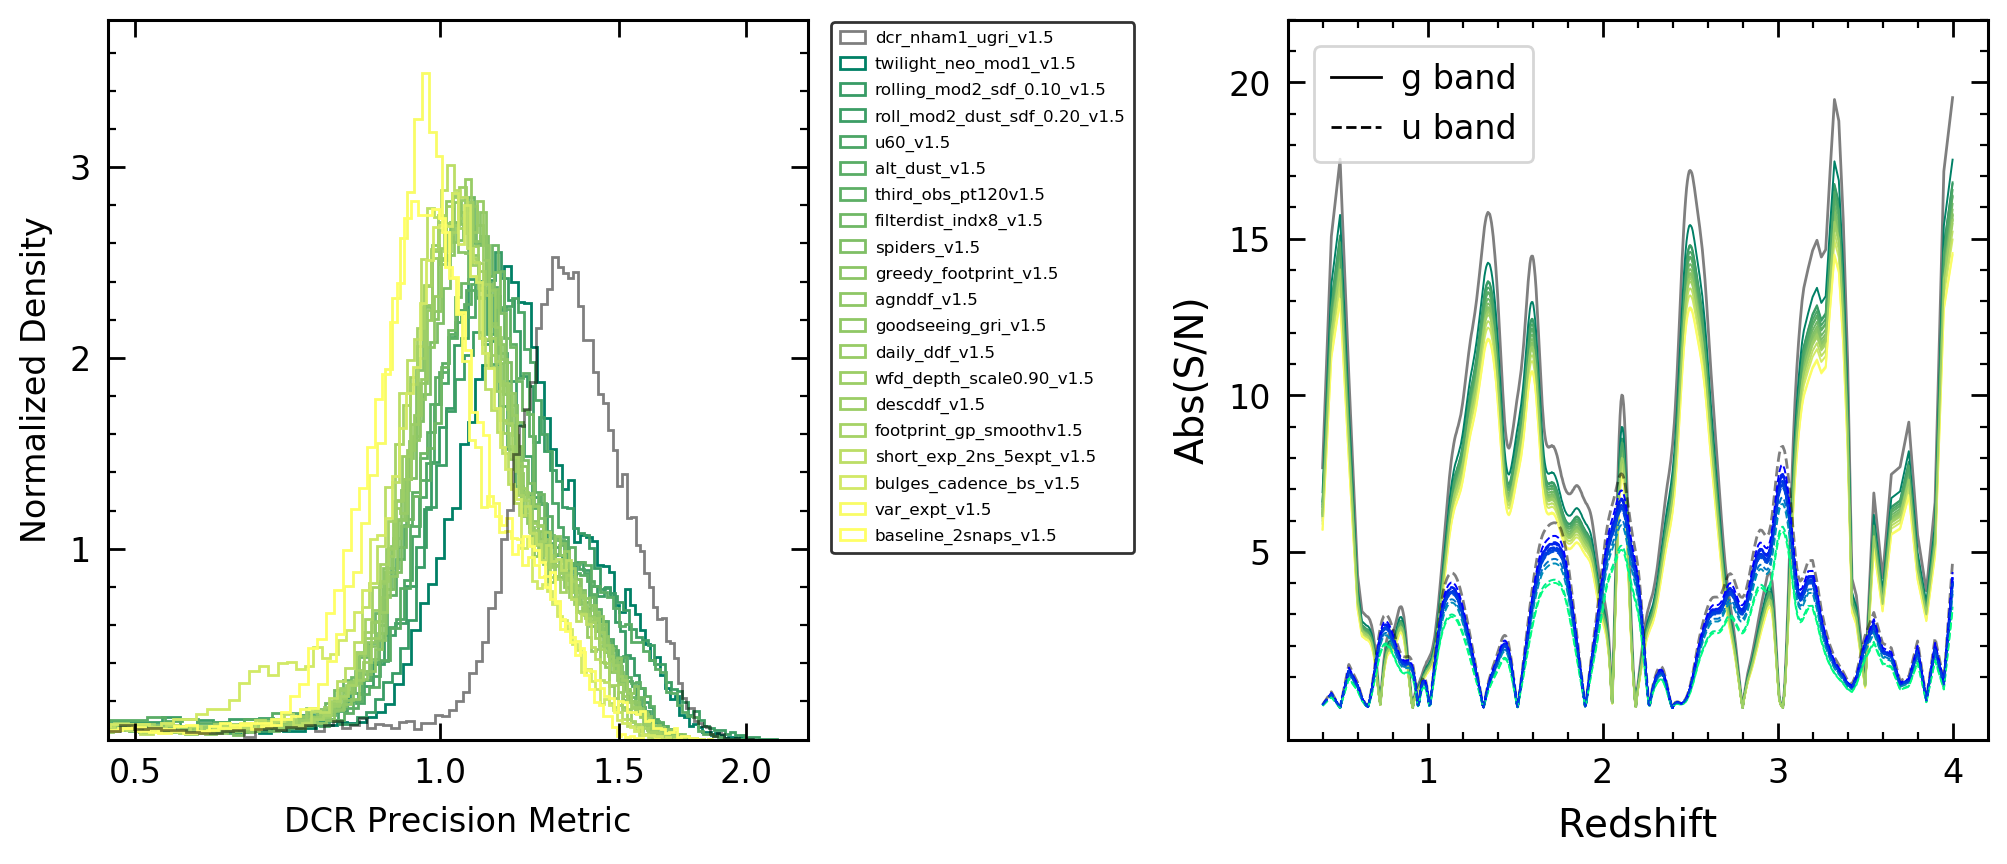

In [11]:
fig = plt.figure(figsize=(10,4.5), dpi=200)
ax1 = fig.add_axes([0.05, 0.15, 0.35, 0.8])
ax2 = fig.add_axes([0.64, 0.15, 0.35, 0.8])
    
# plot right panel
gKey = Key1
uKey = Key2
mds_g = np.sort(get_metric_medians(gKey, bundleDicts, get_dcr_median))
mds_u = np.sort(get_metric_medians(uKey, bundleDicts, get_dcr_median))

# create normalization object
gNorm = mpl.colors.LogNorm(vmin=mds_g[1], vmax=mds_g[-1])
uNorm = mpl.colors.LogNorm(vmin=mds_u[1], vmax=mds_u[-1])
# gNorm = mpl.colors.Normalize(vmin=mds_g[1], vmax=mds_g[-1]*1.04)
# uNorm = mpl.colors.Normalize(vmin=mds_u[1], vmax=mds_u[-1])


# seperate loops for u and g to keep the legend clean
for i, run in enumerate(resultDbsView):

    # look for the correct combination of metricID and metricName 
    keys = [*bundleDicts[run].keys()]
    metricKeyG = [elem for elem in keys if elem[1] == gKey[1]][0]
    md_g = get_dcr_median(bundleDicts[run][metricKeyG])

    if run == 'dcr_nham1_ugri_v1.5_10yrs':
        ax2.plot(dfDCR['zshifts'].values, np.abs(dfDCR['g-slope']/md_g), \
         color='k', linewidth=1, alpha=0.5)
    else:
        ax2.plot(dfDCR['zshifts'].values, np.abs(dfDCR['g-slope']/md_g), \
                 color=mpl.cm.summer(gNorm(md_g)), linewidth=0.7)

# seperate loops for u and g to keep the legend clean
for i, run in enumerate(resultDbsView):

    # look for the correct combination of metricID and metricName 
    keys = [*bundleDicts[run].keys()]
    metricKeyU = [elem for elem in keys if elem[1] == uKey[1]][0]
    md_u = get_dcr_median(bundleDicts[run][metricKeyU])
    
    if run == 'dcr_nham1_ugri_v1.5_10yrs':
        ax2.plot(dfDCR['zshifts'].values, np.abs(dfDCR['u-slope']/md_u), linestyle='--', \
                 color='k', linewidth=1, alpha=0.5)
    else:
        ax2.plot(dfDCR['zshifts'].values, np.abs(dfDCR['u-slope']/md_u), linestyle='--', \
                 color=mpl.cm.winter(uNorm(md_u)), linewidth=0.7)

g_line = ax2.plot([], [], label='g band', linewidth=1, color='k')
u_line = ax2.plot([], [], label='u band', linestyle='--', linewidth=1, color='k')

# option to set uniform ylim
ylim = 22
if ylim is not None:
    ax2.set_ylim(top=ylim, bottom=-1)

ax2.set_xlim(0.2, 4.2)
ax2.tick_params(top=True, right=True, which='both')
ax2.yaxis.set_major_locator(plt.FixedLocator([5, 10, 15, 20]))
ax2.set_xlabel("Redshift")
ax2.set_ylabel("Abs(S/N)")
ax2.legend(handles=(g_line[0], u_line[0]), loc=2)

# get normalization shift
run = 'baseline_2snaps_v1.5_10yrs'
keys = [*bundleDicts[run].keys()]
metricKey = [elem for elem in keys if elem[1] == Key1[1]][0]
norm_precision = get_dcr_median(bundleDicts[run][metricKey])

# get plotting order
unsort_mds_g = get_metric_medians(gKey, bundleDicts, get_dcr_median)
runs = list(bundleDicts.keys())
sort_order = np.argsort(unsort_mds_g)

# plot left panel
for order in sort_order:
    
    run = runs[order]

    # look for the correct combination of metricID and metricName 
    keys = [*bundleDicts[run].keys()]
    metricKey = [elem for elem in keys if elem[1] == Key1[1]][0]

    # need to mask the pixels that have no available data
    mask = bundleDicts[run][metricKey].metricValues.mask
    data = bundleDicts[run][metricKey].metricValues.data[~mask]
    data = data[~(np.isnan(data) | np.isinf(data))]

    # match color to panel2
    md_g = get_dcr_median(bundleDicts[run][metricKey])
    
    # plot    
    if run == 'dcr_nham1_ugri_v1.5_10yrs':
        c = 'k'
        _ = ax1.hist(norm_precision/data, bins='fd', histtype='step', color=c, \
             density=True, alpha=0.5, label=f"{run.rsplit('_', 1)[0]}", zorder = 10)
    else:
        c = mpl.cm.summer(gNorm(md_g))
        _ = ax1.hist(norm_precision/data, bins='fd', histtype='step', color=c, \
             density=True, label=f"{run.rsplit('_', 1)[0]}")
    ax1.set_xscale('log', basex=10)
    
    # tick & format
    ax1.set_xbound(lower=0.47, upper=2.3)
    ax1.tick_params(top=True, right=True, which='both')
    ax1.xaxis.set_major_locator(plt.FixedLocator([0.5, 1, 1.5, 2]))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_minor_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.FixedLocator([1, 2, 3, 4]))
    
    # label & legend
    ax1.set_xlabel('DCR Precision Metric', fontsize=12)
    ax1.set_ylabel('Normalized Density', fontsize=12)
    ax1.legend(fontsize=6, bbox_to_anchor=(1.015, 1.015), edgecolor='k', loc=2, labelspacing=0.6)

# plt.savefig('summer_winters.pdf')